In [150]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# Statistical Modelling

This section of the project will look to set up the statistical models in order to make our predictions for the effectiveness of the bank's marketing campaign based on the dataframe that we have created.


We will begin by creating a Train, Validation and Test split of our data.

We will then look to implement a RFE to see if we should look to drop any of the features we have in our dataset.

Once this is complete, we will set up a baseline model using the Logistic Regression Learner.

We will then look to set up a Decision Tree, Guassian Naive Bayes, Random Forest and Bagged Tree models.

We will also look to hypertune each of the selected models in order to increase the performance of each.

Once all of this is completed, we will select our final model based on the best ROC-AUC score and move onto the threshold selection and model evaluation

In [214]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn import metrics
import seaborn as sns
import itertools
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

In [215]:
def table(string, model_est, X_train, X_val):
    table = pd.DataFrame()
    
    train_accuracy = accuracy_score(y_train, model_est.predict(X_train))
    train_auc = roc_auc_score(y_train, model_est.predict_proba(X_train)[:,1])
    val_accuracy = accuracy_score(y_val, model_est.predict(X_val))
    val_auc = roc_auc_score(y_val, model_est.predict_proba(X_val)[:,1])
    table['Model'] = [string]
    table['Train Accuracy'] = train_accuracy
    table['Train AUC'] = train_auc
    table['Valudation Accuracy'] = val_accuracy
    table['Validation AUC'] = val_auc
    return table

In [216]:
def results_table (model_name, model_est, X_train, X_val):
    name_of_model = []
    train_acc = []
    val_acc = []
    train_auc = []
    val_auc =[]

    name_of_model.append(model_name)
    train_acc.append(accuracy_score(y_train, model_est.predict(X_train)))
    train_auc.append(roc_auc_score(y_train, model_est.predict_proba(X_train)[:,1]))
    val_acc.append(accuracy_score(y_val, model_est.predict(X_val)))
    val_auc.append(roc_auc_score(y_val, model_est.predict_proba(X_val)[:,1]))
        
    data = {"Model Name": model_name, "Train Accuracy" : train_acc, "Validation Accuracy" : val_acc, "Train ROC-AUC": train_auc, "Validation ROC-AUC": val_auc }
    table2 = pd.DataFrame(data)
    return table2

## Reading in the data 

In [222]:
#Reading in the data saved under data_feat and saving it under a variable called data.
data = pd.read_csv('../Data/data_feat.csv')

In [223]:
#Checking the data.
data.head()

,Unnamed: 0,contact,month,day_of_week,campaign,pdays,previous,cons_price_idx,cons_conf_idx,euribor3m,...,job_unemployed,age_group_16-24,age_group_25-34,age_group_35-44,age_group_45-54,age_group_55-64,age_group_65-74,age_group_75-79,Combined_Tax,Feature_2
0,0,1,5,1,1,999,0,93.994,-36.4,4.857,...,0,0,0,0,0,1,0,0,62.0,50914.6344
1,1,1,5,1,1,999,0,93.994,-36.4,4.857,...,0,0,0,0,0,1,0,0,62.0,50914.6344
2,2,1,5,1,1,999,0,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,62.0,50914.6344
3,3,1,5,1,1,999,0,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,62.0,50914.6344
4,4,1,5,1,1,999,0,93.994,-36.4,4.857,...,0,0,0,0,0,1,0,0,62.0,50914.6344


In [224]:
#Dropping unwanted columns.
data.drop(columns=['Unnamed: 0'], inplace=True)

In [225]:
#Checking the data.
data.head()

,contact,month,day_of_week,campaign,pdays,previous,cons_price_idx,cons_conf_idx,euribor3m,y,...,job_unemployed,age_group_16-24,age_group_25-34,age_group_35-44,age_group_45-54,age_group_55-64,age_group_65-74,age_group_75-79,Combined_Tax,Feature_2
0,1,5,1,1,999,0,93.994,-36.4,4.857,0,...,0,0,0,0,0,1,0,0,62.0,50914.6344
1,1,5,1,1,999,0,93.994,-36.4,4.857,0,...,0,0,0,0,0,1,0,0,62.0,50914.6344
2,1,5,1,1,999,0,93.994,-36.4,4.857,0,...,0,0,0,1,0,0,0,0,62.0,50914.6344
3,1,5,1,1,999,0,93.994,-36.4,4.857,0,...,0,0,0,1,0,0,0,0,62.0,50914.6344
4,1,5,1,1,999,0,93.994,-36.4,4.857,0,...,0,0,0,0,0,1,0,0,62.0,50914.6344


In [226]:
#Checking the data.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 52 columns):
contact                     41188 non-null int64
month                       41188 non-null int64
day_of_week                 41188 non-null int64
campaign                    41188 non-null int64
pdays                       41188 non-null int64
previous                    41188 non-null int64
cons_price_idx              41188 non-null float64
cons_conf_idx               41188 non-null float64
euribor3m                   41188 non-null float64
y                           41188 non-null int64
MOM_Inflation               41188 non-null float64
Wage_Growth                 41188 non-null float64
EURUSD                      41188 non-null float64
euro_zoneGDP_Growth_Rate    41188 non-null float64
loan_no                     41188 non-null int64
loan_yes                    41188 non-null int64
housing_no                  41188 non-null int64
housing_yes                 41188 non-null i

In [227]:
#Checking the data.
data.columns

Index(['contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'y', 'MOM_Inflation',
       'Wage_Growth', 'EURUSD', 'euro_zoneGDP_Growth_Rate', 'loan_no',
       'loan_yes', 'housing_no', 'housing_yes', 'marital_divorced',
       'marital_married', 'marital_single', 'poutcome_nonexistent',
       'poutcome_success', 'default_no', 'default_yes', 'edu_basic.4y',
       'edu_basic.6y', 'edu_basic.9y', 'edu_high.school', 'edu_illiterate',
       'edu_professional.course', 'edu_university.degree', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'age_group_16-24',
       'age_group_25-34', 'age_group_35-44', 'age_group_45-54',
       'age_group_55-64', 'age_group_65-74', 'age_group_75-79', 'Combined_Tax',
       'Feature_2'],
      dtype='object')

### Checking the value counts for our target variable 'y'.

In [19]:
#Checking value counts for y.
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

We may have a class imbalance problem. We will look to address this by using class_weight in the hyperparameter section.

## Assigning the X and y variables for our model.

In [20]:
#Drop y column from the dataframe and assign this to X, assign the y column as the target variable.
X = data.drop(columns=['y'], axis=1)
y = data['y']

## Setting up the Train,Test and Validation splits.

In [21]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state = 42)

In [22]:
#Train Validation Split.
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.20, random_state = 42)

In [23]:
#Checking to see the size of each set.
print('Shapes of Each Set')
print('-------------------')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

Shapes of Each Set
-------------------
X_train: (26360, 51)
y_train: (26360,)
X_val: (6590, 51)
y_val: (6590,)
X_test: (8238, 51)
y_test: (8238,)


## Baseline Model

For our baseline model we will look to use the Logistic Regression. The the simplicity of interpretting this model is the reason we picked it as our baseline.

### Logistic Regression

In [24]:
#Setting up the logistic regression model
logreg = LogisticRegression(penalty='none', solver='lbfgs')
log_reg = logreg.fit(X_train, y_train)
log_reg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
log_reg_yval_pred = log_reg.predict(X_val)
log_reg_yval_predproba = log_reg.predict_proba(X_val)
print("Accuracy: ", accuracy_score(y_val, log_reg_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, log_reg_yval_predproba[:,1]))

Accuracy:  0.8992412746585736
ROC_AUC of Baseline model (val) = 0.7461281024037523


In [28]:
results01 = table("Logistic Regression", log_reg, X_train, X_val)
results01

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Logistic Regression,0.89742,0.735581,0.899241,0.746128


## Improving the Baseline Model

### RFE

In [29]:
rfe = RFE(estimator=log_reg, step=1)
rfe = rfe.fit(X_train, y_train)

In [30]:

selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
                                      'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
0,contact,1
26,edu_basic.9y,1
49,Combined_Tax,1
32,job_blue-collar,1
36,job_retired,1
38,job_services,1
21,poutcome_success,1
44,age_group_35-44,1
45,age_group_45-54,1
17,marital_divorced,1


In [31]:
X_train.columns

Index(['contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'MOM_Inflation',
       'Wage_Growth', 'EURUSD', 'euro_zoneGDP_Growth_Rate', 'loan_no',
       'loan_yes', 'housing_no', 'housing_yes', 'marital_divorced',
       'marital_married', 'marital_single', 'poutcome_nonexistent',
       'poutcome_success', 'default_no', 'default_yes', 'edu_basic.4y',
       'edu_basic.6y', 'edu_basic.9y', 'edu_high.school', 'edu_illiterate',
       'edu_professional.course', 'edu_university.degree', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'age_group_16-24',
       'age_group_25-34', 'age_group_35-44', 'age_group_45-54',
       'age_group_55-64', 'age_group_65-74', 'age_group_75-79', 'Combined_Tax',
       'Feature_2'],
      dtype='object')

In [32]:
X_train_rfe = rfe.transform(X_train)
X_val_rfe = rfe.transform(X_val)

In [33]:
log_reg_rfe_model = log_reg.fit(X_train_rfe, y_train)

In [34]:
rfecv = RFECV(estimator=log_reg, step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 11
Best features : Index(['contact', 'euribor3m', 'MOM_Inflation', 'euro_zoneGDP_Growth_Rate',
       'housing_no', 'housing_yes', 'poutcome_success', 'job_blue-collar',
       'job_services', 'age_group_35-44', 'age_group_45-54'],
      dtype='object')


In [35]:
rfecv.grid_scores_

array([0.89283005, 0.89753414, 0.89768589, 0.89772382, 0.89814112,
       0.89817906, 0.89810319, 0.89814112, 0.89817906, 0.89836874,
       0.89844461, 0.89791351, 0.89791351, 0.89795144, 0.8977997 ,
       0.89787557, 0.89787557, 0.89814112, 0.89798938, 0.89791351,
       0.89787557, 0.8977997 , 0.89783763, 0.89742033, 0.89711684,
       0.89745827, 0.89742033, 0.89620637, 0.89639605, 0.89575114,
       0.89647193, 0.89620637, 0.89616844, 0.8961305 , 0.89643399,
       0.89624431, 0.89582701, 0.89586495, 0.89586495, 0.89594082,
       0.89525797, 0.89518209, 0.89522003, 0.8952959 , 0.89601669,
       0.89791351, 0.8977997 , 0.89791351, 0.89817906, 0.89787557,
       0.89787557])

The RFE model suggests that we keep all 52 features in our model. We will proceed on this basis.

### Logistic Regression Hyperparameter Tuning

#### Iteration 1:

In [36]:
param_grid01 = {'C': [0.01,0.1,1,10,100],
             'penalty': ['l1','l2'],
             'solver': ['liblinear','saga']}

In [37]:
log_reg_gs01 = GridSearchCV(log_reg,
                         param_grid01,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True,
                         )

log_reg_gs01.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='none',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [38]:
log_reg_gs01_model = log_reg_gs01.best_estimator_
log_reg_gs01_model

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
#Checking to see the parameters and R-Squared
print(f'best model:{log_reg_gs01.best_params_}')
print(f'best score: {log_reg_gs01.best_score_}')

best model:{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
best score: 0.7806702518508449


In [40]:
log_reg_gs01_yval_pred = log_reg_gs01_model.predict(X_val)
log_reg_gs01_yval_predprob = log_reg_gs01_model.predict_proba(X_val)
print("Accuracy:", accuracy_score(y_val, log_reg_gs01_yval_pred))
print("ROC_AUC of model:", roc_auc_score(y_val, log_reg_gs01_yval_predprob[:,1]))

Accuracy: 0.9013657056145675
ROC_AUC of model: 0.7880138946759047


In [41]:
results02 = table("Logistic Regression GS 01", log_reg_gs01_model, X_train, X_val)
results02

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Logistic Regression GS 01,0.898596,0.782935,0.901366,0.788014


#### Iteration 2:

In [42]:
param_grid02 = {'C': [0.5,1,5,10],
             'penalty': ['l1','l2'],
             'solver': ['liblinear','saga']}

In [43]:
log_reg_gs02 = GridSearchCV(log_reg,
                         param_grid02,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

log_reg_gs02.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='none',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1, 5, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [44]:
log_reg_gs02_model = log_reg_gs02.best_estimator_
log_reg_gs02_model

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
log_reg_gs02_yval_pred = log_reg_gs02_model.predict(X_val)
log_reg_gs02_yval_predprob = log_reg_gs02_model.predict_proba(X_val)
print("Accuracy:", accuracy_score(y_val, log_reg_gs02_yval_pred))
print("ROC_AUC of model:", roc_auc_score(y_val, log_reg_gs02_yval_predprob[:,1]))

Accuracy: 0.9006069802731411
ROC_AUC of model: 0.7866719471904602


In [46]:
results03 = table("Logistic Regression GS 02", log_reg_gs02_model, X_train, X_val)
results03

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Logistic Regression GS 02,0.898407,0.783471,0.900607,0.786672


#### Iteration 3:

In [47]:
param_grid03 = {'C': [0,0.1,0.5],
             'penalty': ['l1','l2'],
             'solver': ['liblinear','saga'],
            'class_weight': [None,'balanced'],
            
             }

In [48]:
log_reg_gs03 = GridSearchCV(log_reg,
                         param_grid03,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

log_reg_gs03.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='none',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0, 0.1, 0.5], 'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [49]:
log_reg_gs03_model = log_reg_gs03.best_estimator_
log_reg_gs03_model

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
log_reg_gs03_yval_pred = log_reg_gs03_model.predict(X_val)
log_reg_gs03_yval_predprob = log_reg_gs03_model.predict_proba(X_val)
print("Accuracy:", accuracy_score(y_val, log_reg_gs03_yval_pred))
print("ROC_AUC of model:", roc_auc_score(y_val, log_reg_gs03_yval_predprob[:,1]))

Accuracy: 0.7795144157814871
ROC_AUC of model: 0.788247577442561


In [51]:
results04 = table("Logistic Regression GS 03", log_reg_gs03_model, X_train, X_val)
results04

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Logistic Regression GS 03,0.778566,0.784903,0.779514,0.788248


#### Logistic Regression Hyperparameter Results Summary

In [52]:
cm01 = sns.light_palette("blue", as_cmap=True)

In [235]:
log_reg_df = pd.DataFrame()
log_reg_df.append([results01, 
                   results02, 
                   results03, 
                   results04],
                  ignore_index=True).style.background_gradient(cmap=cm01).highlight_max(color='red')

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Logistic Regression,0.89742,0.735581,0.899241,0.746128
1,Logistic Regression GS 01,0.898596,0.782935,0.901366,0.788014
2,Logistic Regression GS 02,0.898407,0.783471,0.900607,0.786672
3,Logistic Regression GS 03,0.778566,0.784903,0.779514,0.788248


As can be seen in the table above, the best performing model out of the hyperparameter tuned Logistic Regression is from log_reg_gs03_model.

We will now move onto Decision Trees

### Decision Tree

In [54]:
dec_tree = DecisionTreeClassifier(criterion='entropy')

dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [57]:
dec_tree_yval_pred = dec_tree.predict(X_val)
dec_tree_yval_predprob = dec_tree.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, dec_tree_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, dec_tree_yval_predprob[:,1]))

Accuracy:  0.8491654021244309
ROC_AUC of Baseline model (val) = 0.6332505687663393


In [236]:
results05 = table("Decision Tree", dec_tree, X_train, X_val)
results05

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree,0.991199,0.999577,0.849165,0.633251


In [237]:
table("Decision Tree", dec_tree, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree,0.991199,0.999577,0.849165,0.633251


### Decision Tree Hyperparameter Tuning

#### Iteration 1:

In [60]:
param_grid04 = {'max_depth':[1,10,100],
                             'min_samples_leaf':[5,10,50]}

In [61]:
dec_tree_gs01 = GridSearchCV(dec_tree,
                         param_grid04,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

dec_tree_gs01.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 10, 100],
                       

In [62]:
dec_tree_gs01_model = dec_tree_gs01.best_estimator_
dec_tree_gs01_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [63]:
dec_tree_gs01_yval_pred = dec_tree_gs01_model.predict(X_val)
dec_tree_gs01_yval_predprob = dec_tree_gs01_model.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, dec_tree_gs01_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, dec_tree_gs01_yval_predprob[:,1]))

Accuracy:  0.8977238239757208
ROC_AUC of Baseline model (val) = 0.7907625478888352


In [64]:
results06 = table("Decision Tree GS 01", dec_tree_gs01, X_train, X_val)
results06

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree GS 01,0.903338,0.835154,0.897724,0.790763


In [65]:
table('Decision Tree GS01', dec_tree_gs01, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree GS01,0.903338,0.835154,0.897724,0.790763


#### Iteration 2:

In [66]:
param_grid05 = {'max_depth':range(10, 20,30),
                             'min_samples_leaf':[15,20,25,30]}

In [67]:
dec_tree_gs02 = GridSearchCV(dec_tree,
                         param_grid05,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

dec_tree_gs02.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(10, 20, 30),
                  

In [68]:
dec_tree_gs02_model = dec_tree_gs02.best_estimator_
dec_tree_gs02_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [69]:
dec_tree_gs02_yval_pred = dec_tree_gs02_model.predict(X_val)
dec_tree_gs02_yval_predproba = dec_tree_gs02_model.predict_proba(X_val)[:,1]
print('Accuracy: ', accuracy_score(y_val, dec_tree_gs02_yval_pred))
print('ROC_AUC Score: ', roc_auc_score(y_val, dec_tree_gs02_yval_predproba))

Accuracy:  0.8983308042488619
ROC_AUC Score:  0.7909349292591104


In [70]:
results07 = table("Decision Tree GS 02", dec_tree_gs02, X_train, X_val)
results07

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree GS 02,0.90698,0.841593,0.898331,0.790935


In [71]:
table('Decision Tree GS02', dec_tree_gs02, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree GS02,0.90698,0.841593,0.898331,0.790935


#### Iteration 3:

In [72]:
param_grid06 = {'max_depth':range(5,10,15),
                'min_samples_leaf':[15,25,30,50],
               'class_weight': [None,'balanced'],
               'criterion': ['gini','entropy']}

In [73]:
dec_tree_gs03 = GridSearchCV(dec_tree,
                         param_grid06,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

dec_tree_gs03.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': [None, 'balanced'],
              

In [74]:
dec_tree_gs03_model = dec_tree_gs03.best_estimator_
dec_tree_gs03_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [75]:
dec_tree_gs03_yval_pred = dec_tree_gs03_model.predict(X_val)
dec_tree_gs03_yval_predprob = dec_tree_gs03_model.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, dec_tree_gs03_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, dec_tree_gs03_yval_predprob[:,1]))

Accuracy:  0.9021244309559939
ROC_AUC of Baseline model (val) = 0.7974725157724345


In [76]:
results08 = table("Decision Tree GS 03", dec_tree_gs03, X_train, X_val)
results08

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree GS 03,0.90258,0.797805,0.902124,0.797473


In [77]:
table('Decision Tree GS03', dec_tree_gs03, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree GS03,0.90258,0.797805,0.902124,0.797473


#### Decision Tree Hyperparameter Results Summary

In [78]:
cm02 = sns.light_palette("green", as_cmap=True)

In [79]:
dec_tree_df = pd.DataFrame()
dec_tree_df.append([results05, 
                    results06, 
                    results07, 
                    results08]
                   ,ignore_index=True).style.background_gradient(cmap=cm02).highlight_max(color='red')

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree,0.991199,0.999577,0.849165,0.633251
1,Decision Tree GS 01,0.903338,0.835154,0.897724,0.790763
2,Decision Tree GS 02,0.90698,0.841593,0.898331,0.790935
3,Decision Tree GS 03,0.90258,0.797805,0.902124,0.797473


Our best performing model out of the Decision Tree hyperparameter tuned models is dec_tree_gs03_model.

### Gaussian Naive Bayes

In [80]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [81]:
GNB_yval_pred = gnb.predict(X_val)
GNB_yval_predprob = gnb.predict_proba(X_val)
print("Accuracy:",metrics.accuracy_score(y_val, GNB_yval_pred))
print("ROC_AUC of Baseline model (test) =", roc_auc_score(y_val, GNB_yval_predprob[:,1]))

Accuracy: 0.8770864946889226
ROC_AUC of Baseline model (test) = 0.7770426731464855


In [82]:
results09 = table("Gaussian Naive Bayes", gnb, X_train, X_val)
results09

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Gaussian Naive Bayes,0.880387,0.771052,0.877086,0.777043


In [83]:
table("Gaussian Naive Bayes", gnb, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Gaussian Naive Bayes,0.880387,0.771052,0.877086,0.777043


### Random Forest

In [84]:
ran_for = RandomForestClassifier()
ran_for.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [85]:
ran_for.score(X_train, y_train)

0.9911229135053111

In [86]:
results10 = table("Random Forest", ran_for, X_train, X_val)
results10

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest,0.991123,0.999328,0.894841,0.774321


In [87]:
table('Random Forest', ran_for, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest,0.991123,0.999328,0.894841,0.774321


### Random Forest Hyperparameter Tuning

#### Iteration 1:

In [88]:
param_grid08 = {'max_depth':range(10,50+1,10),
                'min_samples_leaf':[5,10,15,20],
                'criterion':['gini', "entropy"],
               'class_weight': [None,'balanced']}

In [89]:
ran_for_gs01 = GridSearchCV(ran_for,
                         param_grid08,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

ran_for_gs01.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [90]:
ran_for_gs01_model = ran_for_gs01.best_estimator_
ran_for_gs01_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [91]:
table("Random Forest GS01",ran_for_gs01, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS01,0.859181,0.845764,0.858574,0.806518


In [92]:
ran_for_gs01_yval_pred = ran_for_gs01_model.predict(X_val)
ran_for_gs01_yval_predprob = ran_for_gs01_model.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, ran_for_gs01_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, ran_for_gs01_yval_predprob[:,1]))

Accuracy:  0.8585735963581184
ROC_AUC of Baseline model (val) = 0.806517582899768


In [93]:
results11 = table("Random Forest GS01", ran_for_gs01, X_train, X_val)
results11

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS01,0.859181,0.845764,0.858574,0.806518


#### Iteration 2:

In [94]:
param_grid09 = {'max_depth':[5,10,20],
                'min_samples_leaf':[10,15,20],
                'criterion':['gini', "entropy"],
               'class_weight': [None,'balanced']}

In [95]:
ran_for_gs02 = GridSearchCV(ran_for,
                         param_grid09,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

ran_for_gs02.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [96]:
ran_for_gs02_model = ran_for_gs02.best_estimator_
ran_for_gs02_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [97]:
ran_for_gs02_yval_pred = ran_for_gs02_model.predict(X_val)
ran_for_gs02_yval_predprob = ran_for_gs02_model.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, ran_for_gs02_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, ran_for_gs02_yval_predprob[:,1]))

Accuracy:  0.8603945371775418
ROC_AUC of Baseline model (val) = 0.8057460149483224


In [98]:
ran_for_gs02_ytrain_pred = ran_for_gs02_model.predict(X_train)
ran_for_gs02_ytrain_predprob = ran_for_gs02_model.predict_proba(X_train)
print('Accuracy: ', accuracy_score(y_train, ran_for_gs02_ytrain_pred))
print("ROC_AUC of Baseline model (train) =", roc_auc_score(y_train, ran_for_gs02_ytrain_predprob[:,1]))

Accuracy:  0.8601669195751138
ROC_AUC of Baseline model (train) = 0.8514062490105525


In [99]:
ran_for_gs02_ytest_pred = ran_for_gs02_model.predict(X_test)
ran_for_gs02_ytest_predprob = ran_for_gs02_model.predict_proba(X_test)
print('Accuracy: ', accuracy_score(y_test, ran_for_gs02_ytest_pred))
print("ROC_AUC of Baseline model (test) =", roc_auc_score(y_test, ran_for_gs02_ytest_predprob[:,1]))

Accuracy:  0.855668851663025
ROC_AUC of Baseline model (test) = 0.789812112962148


In [100]:
results12 = table("Random Forest GS02", ran_for_gs02, X_train, X_val)
results12

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS02,0.860167,0.851406,0.860395,0.805746


In [101]:
table("Random Forest GS02", ran_for_gs02_model, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS02,0.860167,0.851406,0.860395,0.805746


#### Iteration 3:

In [102]:
param_grid10 = {'max_depth':[5,10,20],
                'min_samples_leaf':[3,5,10],
                'criterion':['gini', "entropy"],
               'class_weight': [None,'balanced']}

In [103]:
ran_for_gs03 = GridSearchCV(ran_for,
                         param_grid10,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

ran_for_gs03.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [104]:
ran_for_gs03_model = ran_for_gs03.best_estimator_
ran_for_gs03_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [105]:
ran_for_gs03_yval_pred = ran_for_gs03_model.predict(X_val)
ran_for_gs03_yval_predprob = ran_for_gs03_model.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, ran_for_gs03_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, ran_for_gs03_yval_predprob[:,1]))

Accuracy:  0.860546282245827
ROC_AUC of Baseline model (val) = 0.806591559396905


In [106]:
results13 = table("Random Forest GS03", ran_for_gs03, X_train, X_val)
results13

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS03,0.860167,0.849447,0.860546,0.806592


In [107]:
table("Random Forest GS04", ran_for_gs03_model, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS04,0.860167,0.849447,0.860546,0.806592


#### Iteration 4:

In [110]:
param_grid11 = {'max_depth':[10],
                'min_samples_leaf':[10],
                'criterion':['gini', "entropy"],
               'class_weight': [None,'balanced'],
               'n_estimators' :[100,200,300]}

In [111]:
ran_for_gs04 = GridSearchCV(ran_for,
                         param_grid11,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

ran_for_gs04.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [112]:
ran_for_gs04.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 10,
 'n_estimators': 300}

In [113]:
ran_for_gs04_model = ran_for_gs04.best_estimator_
ran_for_gs04_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [114]:
ran_for_gs04_yval_pred = ran_for_gs04_model.predict(X_val)
ran_for_gs04_yval_predprob = ran_for_gs04_model.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, ran_for_gs04_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, ran_for_gs04_yval_predprob[:,1]))

Accuracy:  0.8610015174506829
ROC_AUC of Baseline model (val) = 0.8072202443943791


In [115]:
results14 = table("Random Forest GS04", ran_for_gs04, X_train, X_val)
results14

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS04,0.860964,0.850998,0.861002,0.80722


In [116]:
table("Random Forest GS04", ran_for_gs04_model, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS04,0.860964,0.850998,0.861002,0.80722


### Random Forest Hyperparameter Results Summary

In [117]:
cm03 = sns.light_palette("yellow", as_cmap=True)

In [118]:
ran_for_df = pd.DataFrame()
ran_for_df.append([results10, 
                    results11, 
                    results12, 
                    results13,
                    results14]
                   ,ignore_index=True).style.background_gradient(cmap=cm03).highlight_max(color='red')

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest,0.991123,0.999328,0.894841,0.774321
1,Random Forest GS01,0.859181,0.845764,0.858574,0.806518
2,Random Forest GS02,0.860167,0.851406,0.860395,0.805746
3,Random Forest GS03,0.860167,0.849447,0.860546,0.806592
4,Random Forest GS04,0.860964,0.850998,0.861002,0.80722


Our best performing model out of the Randome Forest hyperparameter tuned models is ran_for_gs04_model.

## Ensemble Methods

### Bagged Tree

In [119]:
bag_tree =  BaggingClassifier(DecisionTreeClassifier())

In [120]:
bag_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [121]:
bag_tree.score(X_train, y_train)

0.980083459787557

In [122]:
bag_tree.score(X_val, y_val)

0.8869499241274659

In [123]:
results15 = table("Bagged Tree", bag_tree, X_train, X_val)
results15

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Bagged Tree,0.980083,0.997335,0.88695,0.749458


In [124]:
table('Bagged Tree', bag_tree, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Bagged Tree,0.980083,0.997335,0.88695,0.749458


### XG Boost

In [129]:
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [131]:
xgb_yval_pred = xgb.predict(X_val)
xgb_yval_predprob = xgb.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, xgb_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, xgb_yval_predprob[:,1]))

Accuracy:  0.896206373292868
ROC_AUC of Baseline model (val) = 0.7952440026032351


In [132]:
results16 = table("XG Boost", xgb, X_train, X_val)
results16

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,XG Boost,0.931184,0.911382,0.896206,0.795244


In [133]:
table("XGBoost", xgb, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,XGBoost,0.931184,0.911382,0.896206,0.795244


### Voting Classifiers

In [138]:
clf1 = log_reg_gs03_model
clf2 = dec_tree_gs03_model
clf3 = gnb
clf4 = ran_for_gs04_model

In [143]:
vc =  VotingClassifier(estimators=[('lr', clf1), ('dt', clf2), ('gnb', clf3), ('rf',clf4)], voting='soft')
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('dt',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criteri...
                                        

In [144]:
vc_ytrain_pred = vc.predict(X_train)
vc_ytrain_predprob = vc.predict_proba(X_train)
print('Accuracy: ', accuracy_score(y_train, vc_ytrain_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_train, vc_ytrain_predprob[:,1]))

Accuracy:  0.8816009104704097
ROC_AUC of Baseline model (val) = 0.8186901245924451


In [145]:
vc_yval_pred = vc.predict(X_val)
vc_yval_predprob = vc.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, vc_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, vc_yval_predprob[:,1]))

Accuracy:  0.8769347496206373
ROC_AUC of Baseline model (val) = 0.8002201319316669


In [147]:
vc_ytest_pred = vc.predict(X_test)
vc_ytest_predprob = vc.predict_proba(X_test)
print('Accuracy: ', accuracy_score(y_test, vc_ytest_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_test, vc_ytest_predprob[:,1]))

Accuracy:  0.8750910415149308
ROC_AUC of Baseline model (val) = 0.7854660856537603


In [149]:
results17 = table("Voting Classifier", vc, X_train, X_val)
results17

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Voting Classifier,0.881601,0.81869,0.876935,0.80022


In [150]:
table("Voting CLassifier", vc, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Voting CLassifier,0.881601,0.81869,0.876935,0.80022


## Summarising all the models

In [151]:
cm = sns.light_palette("purple", as_cmap=True)

In [152]:
results_summary = pd.DataFrame()
results_summary.append([results01,
                        results02, 
                        results03,
                        results04,
                        results05,
                        results06,
                        results07,
                        results08,
                        results09,
                        results10,
                        results11, 
                        results12, 
                        results13, 
                        results14, 
                        results15, 
                        results16, 
                        results17], ignore_index=True).style.background_gradient(cmap=cm).highlight_max(color='red')

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Logistic Regression,0.89742,0.735581,0.899241,0.746128
1,Logistic Regression GS 01,0.898596,0.782935,0.901366,0.788014
2,Logistic Regression GS 02,0.898407,0.783471,0.900607,0.786672
3,Logistic Regression GS 03,0.778566,0.784903,0.779514,0.788248
4,Decision Tree,0.991199,0.999577,0.849165,0.633251
5,Decision Tree GS 01,0.903338,0.835154,0.897724,0.790763
6,Decision Tree GS 02,0.90698,0.841593,0.898331,0.790935
7,Decision Tree GS 03,0.90258,0.797805,0.902124,0.797473
8,Gaussian Naive Bayes,0.880387,0.771052,0.877086,0.777043
9,Random Forest,0.991123,0.999328,0.894841,0.774321


## Interpretting the best performing model

In [182]:
pd.DataFrame.from_dict(ran_for_gs04.best_params_, orient='index').rename(columns={0:'Parameters'})

,Parameters
class_weight,balanced
criterion,entropy
max_depth,10
min_samples_leaf,10
n_estimators,300


In [153]:
ran_for_gs04_model.feature_importances_

array([0.02618488, 0.04233458, 0.01614916, 0.02371089, 0.05845311,
       0.01703133, 0.05671679, 0.07440069, 0.19029875, 0.02143568,
       0.06352826, 0.05379446, 0.03240274, 0.00347583, 0.00348586,
       0.00536649, 0.00557899, 0.00312243, 0.00540704, 0.00584807,
       0.01377273, 0.04461672, 0.00892091, 0.        , 0.00339998,
       0.00212905, 0.0035877 , 0.00432029, 0.        , 0.00332109,
       0.006057  , 0.00371908, 0.00520553, 0.00128954, 0.00257504,
       0.00251329, 0.00307494, 0.00164674, 0.00367144, 0.0018347 ,
       0.00340851, 0.0011622 , 0.00172537, 0.00569198, 0.00955778,
       0.00636426, 0.00266099, 0.00117225, 0.00027149, 0.00815291,
       0.13545043])

In [154]:
features_df = pd.DataFrame(ran_for_gs04_model.feature_importances_, X.columns).rename(columns={0:'Importance'}).sort_values('Importance', ascending=False)

In [155]:
features_df.head()

,Importance
euribor3m,0.190299
Feature_2,0.135450
cons_conf_idx,0.074401
Wage_Growth,0.063528
pdays,0.058453


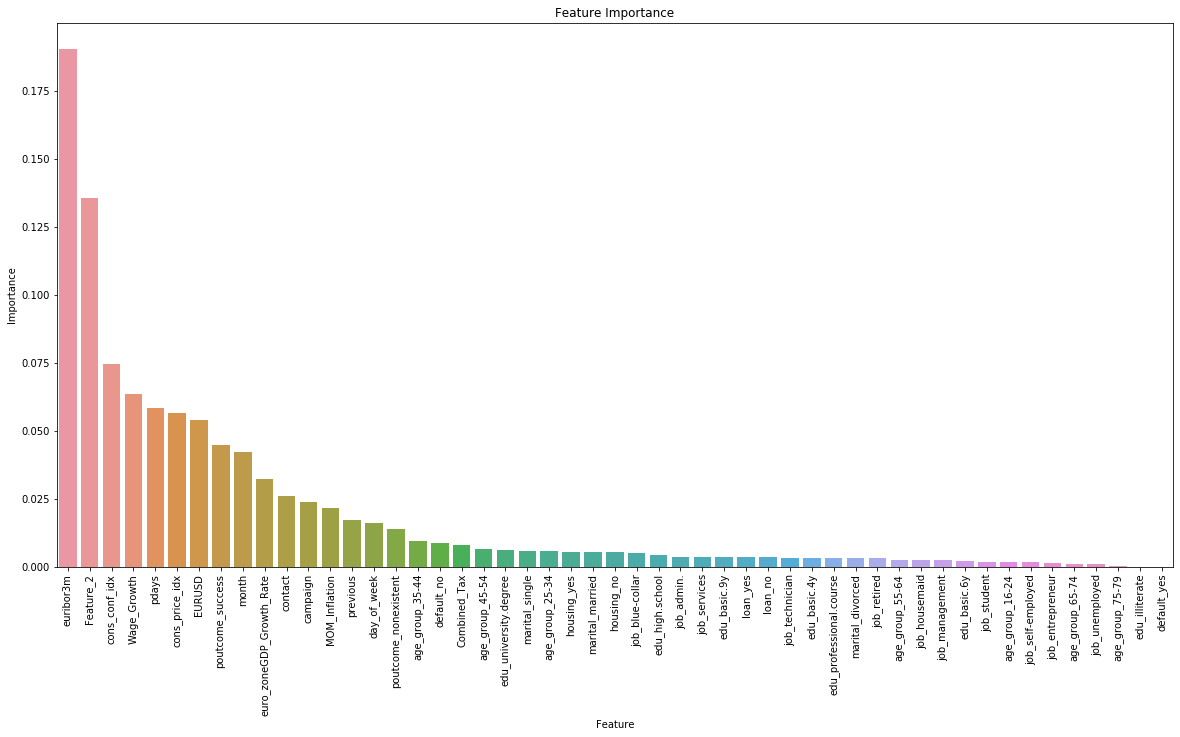

In [238]:
n_features = X.shape[1]
plt.figure(figsize=(20,10))
sns.barplot(features_df.index, features_df['Importance'],data=features_df)
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.xlabel('Feature')
plt.show()

In [188]:
ran_for_gs04_ytest_pred = ran_for_gs04_model.predict(X_test)
ran_for_gs04_ytest_predprob = ran_for_gs04_model.predict_proba(X_test)
print('Accuracy: ', accuracy_score(y_test, ran_for_gs04_ytest_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_test, ran_for_gs04_ytest_predprob[:,1]))

Accuracy:  0.856275795095897
ROC_AUC of Baseline model (val) = 0.7904881226014362


In [159]:
cnf_matrix = confusion_matrix(y_test, ran_for_gs04_ytest_pred)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[6509  794]
 [ 390  545]]


In [160]:
TN = cnf_matrix[0][0]
TP = cnf_matrix[1][1]
FN = cnf_matrix[1][0]
FP = cnf_matrix[0][1]

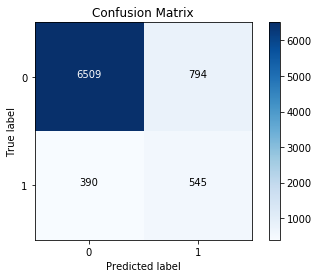

In [161]:
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
class_names = set(y) # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

# Add a legend
plt.colorbar()
plt.show()

In [162]:
# Calculate the probability scores of each point in the training set
y_train_score = ran_for_gs04_model.predict_proba(X_train)[:,1]

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Calculate the probability scores of each point in the test set
y_test_score = ran_for_gs04_model.predict_proba(X_test)[:,1]

# Calculate the fpr, tpr, and thresholds for the test set
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

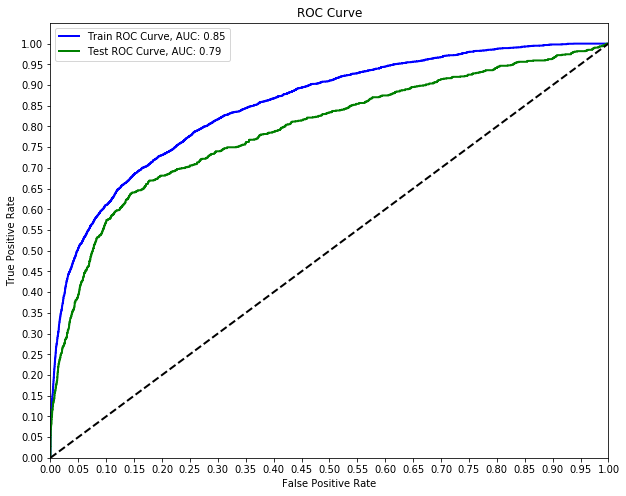

In [213]:
# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
x1 = auc(train_fpr, train_tpr)
x2 = auc(test_fpr, test_tpr)
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label=f'Train ROC Curve, AUC: {np.round(x1,2)}')
plt.plot(test_fpr, test_tpr, color='green',
         lw=lw, label=f'Test ROC Curve, AUC: {np.round(x2,2)}')
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='upper left')

plt.show()

In [204]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

In [203]:
X_test.iloc[:,0]

32884    0
3169     1
32206    0
9403     1
14020    0
        ..
12322    1
23440    0
29431    0
16627    0
1871     1
Name: contact, Length: 8238, dtype: int64